In [ ]:
!pip install chart-studio
#Importing libraries required
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import datetime
import warnings
import os
import seaborn as sns
from google.colab import drive
from statsmodels.tsa.seasonal import seasonal_decompose #decompose seasonality
from statsmodels.tsa.stattools import adfuller #test if series is stationary (then can perform SARIMAX)
import statsmodels.api as sm
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from fbprophet import Prophet
import holidays
from sklearn.model_selection import train_test_split, cross_val_score,KFold
from sklearn import datasets, linear_model, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoCV
from sklearn import preprocessing, svm

In [ ]:
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/CZ4041_MLProject_Group20') # update this path accordingly if your google drive path is different

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
train_path = 'data/train.csv' 
test_path = 'data/test.csv'
holidays_path = 'data/USHolidayDates.csv'

# Exploratory Data Analysis & Data Preparation
1. Basic data exploration
2. Time series data exploration
3. Feature engineering


## 1. Basic data exploration

In [ ]:
train = pd.read_csv(train_path, parse_dates = ['date']) # load dataset
test = pd.read_csv(test_path) # load dataset

In [ ]:
print('shape of train data: {} shape of test data: {}'.format(train.shape, test.shape))
print('missing values: {}'.format(train.isnull().sum().sum()))
print('number of unique stores: {} '.format(train[["store"]].nunique()['store']))
print('number of unique items: {} '.format(train[["item"]].nunique()['item']))
print('Time period of train data and test data')
print('train data-----------------')
print('start date: {}'.format(train['date'].min().date()))
print('end date: {}'.format(train['date'].max().date()))

print('test data-----------------')
print('start date: {}'.format(test['date'].min()))
print('end date: {}'.format(test['date'].max()))

#train['date'].min(), train['date'].max(), (data['date'].max() -data['date'].min())

shape of train data: (913000, 4) shape of test data: (45000, 4)
missing values: 0
number of unique stores: 10 
number of unique items: 50 
Time period of train data and test data
train data-----------------
start date: 2013-01-01
end date: 2017-12-31
test data-----------------
start date: 2018-01-01
end date: 2018-03-31


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [ ]:
eda_df = train.copy()
# Number of unique items for each store, all shops are selling all 50 items.
eda_df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [ ]:
# Distribution of sales
eda_df = train.copy()
#eda_df["sales"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])
eda_df.describe()

store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000

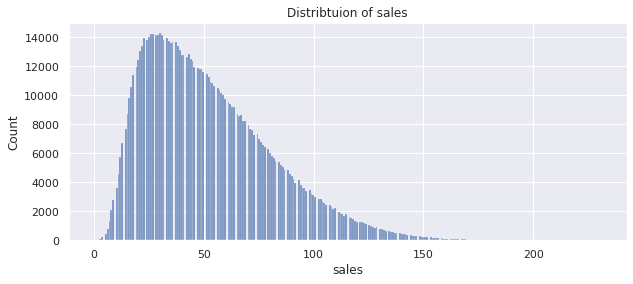

In [ ]:
sns.set(rc={"figure.figsize":(10, 4)})
ax = sns.histplot(x=eda_df["sales"]).set_title('Distribtuion of sales')

In [ ]:
#Sales distribution and statistics per store and item
eda_df = train.copy()
test = eda_df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})
test.head()

sales                             
              sum       mean median        std
store item                                    
1     1     36468  19.971522   19.0   6.741022
      2     97050  53.148959   52.0  15.005779
      3     60638  33.208105   33.0  10.072529
      4     36440  19.956188   20.0   6.640618
      5     30335  16.612815   16.0   5.672102

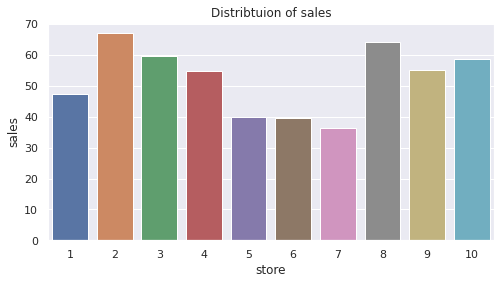

In [ ]:
eda_df = train.copy()
store_mean = eda_df.groupby(["store"]).mean()
store_mean.head()
sns.set(rc={"figure.figsize":(8, 4)})
ax = sns.barplot(data = store_mean, x=store_mean.index, y = store_mean["sales"]) .set_title('Distribtuion of sales')

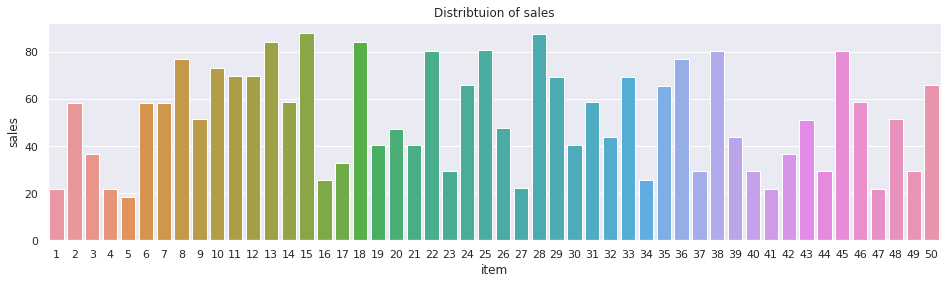

In [ ]:
item_mean = eda_df.groupby(["item"]).mean()
sns.set(rc={"figure.figsize":(16, 4)})
ax = sns.barplot(data = item_mean, x=item_mean.index, y = item_mean["sales"]) .set_title('Distribtuion of sales')

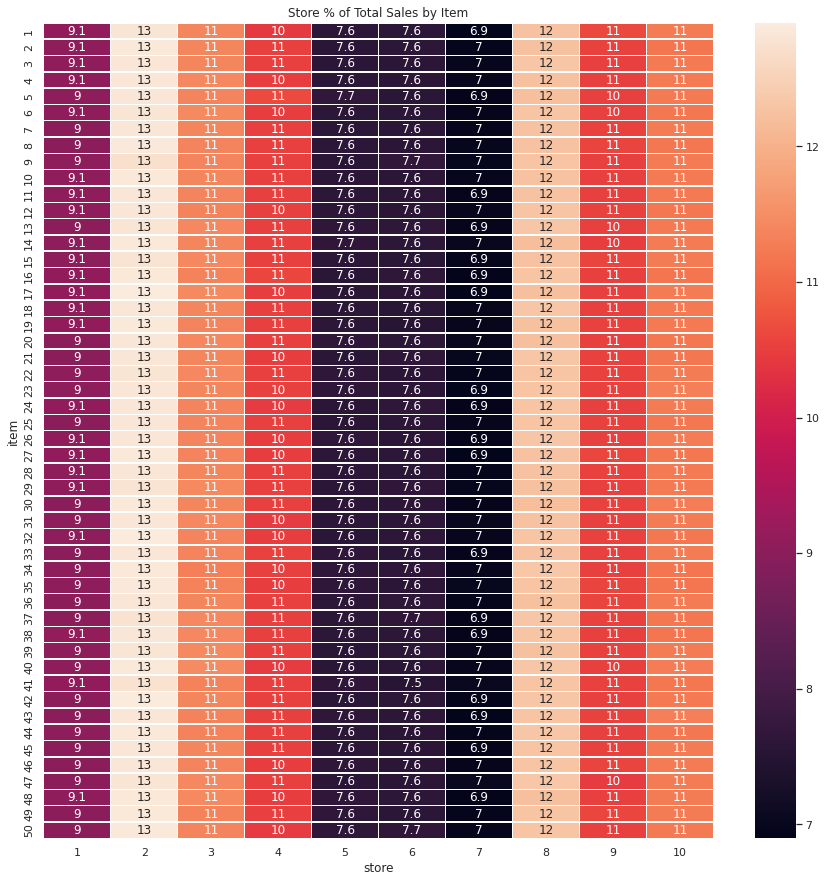

In [ ]:
#Store item variability - find stores sell more of a certain item and if items are sold evenly across stores.
eda_df = train.copy()
store_item = eda_df.groupby(by=['item','store']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack()
fig, ax = plt.subplots(figsize=(15,15))    
sns.heatmap(store_item, annot=True, linewidths=.5, ax=ax).set_title(
  'Store % of Total Sales by Item'
)
plt.show()

observation: The Store % of Total Sales by Item is quite consistentfor all shops, meaning all shops generally sell the same amount of items.

## 2. Time series data exploration

*   Overall sales trend  
*   Store sales trend
*   Item sales trend


 


In [ ]:
#Overall sales trend
daily_overall_sales = train.groupby('date', as_index=False)['sales'].sum()
daily_overall_sales_sc = go.Scatter(x=daily_overall_sales['date'], y=daily_overall_sales['sales'])
layout = go.Layout(title='Daily Overall Sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_overall_sales_sc], layout=layout)
iplot(fig)

<Figure size 1152x288 with 0 Axes>

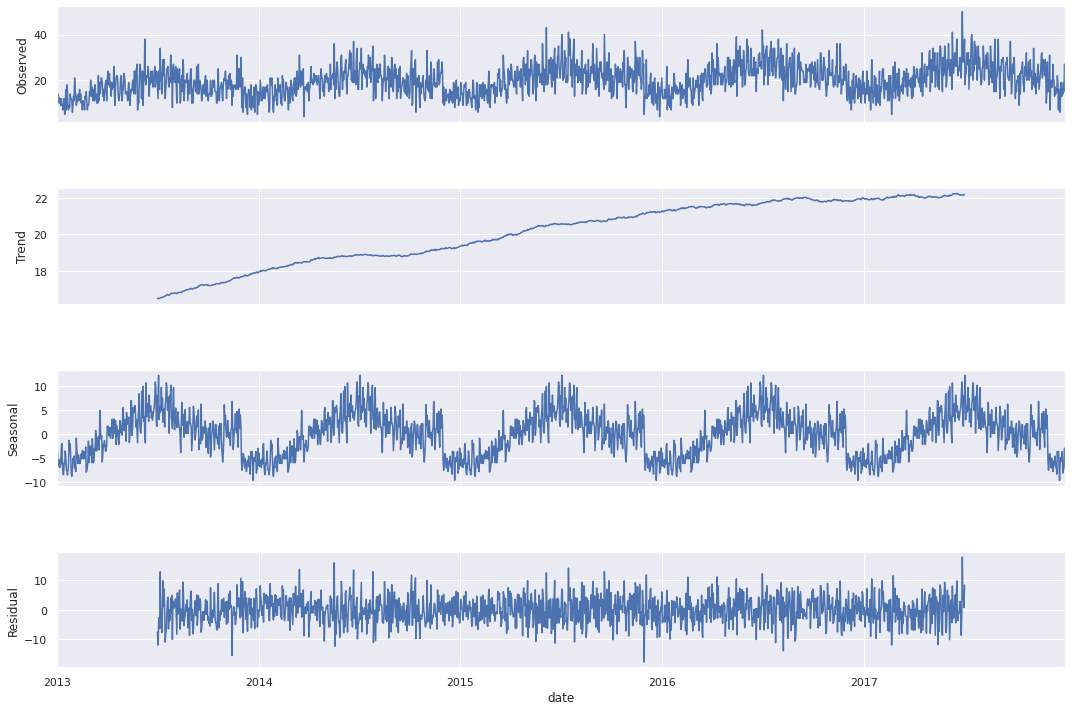

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
eda_df = train.copy()
eda_df = eda_df.set_index('date')
#looking at a sub sample
eda_df = eda_df[eda_df['store']==1]
eda_df = eda_df[eda_df['item']==1]
# Using time-series decomposition to visualize data
result = seasonal_decompose(eda_df['sales'], model='additive', freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)


Observation: 

TREND: Increasing pattern observed over the period. In this case, the gradual increase underlying trend is observed. (i.e. the total number of sales has increased over a period of time.)

SEASONAILITY: There is a similiar patern that repears after a certain interval of time. There is a certain high and low point that is visible in all intervals.



In [ ]:
#Store sales trend
daily_sales_by_store = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
store_daily_sales_sc = []
for store in daily_sales_by_store['store'].unique():
    current_store = daily_sales_by_store[(daily_sales_by_store['store'] == store)]
    store_daily_sales_sc.append(go.Scatter(x=current_store['date'], y=current_store['sales'], name=('Store %s' % store)))

layout = go.Layout(title='Store daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=store_daily_sales_sc, layout=layout)
iplot(fig)

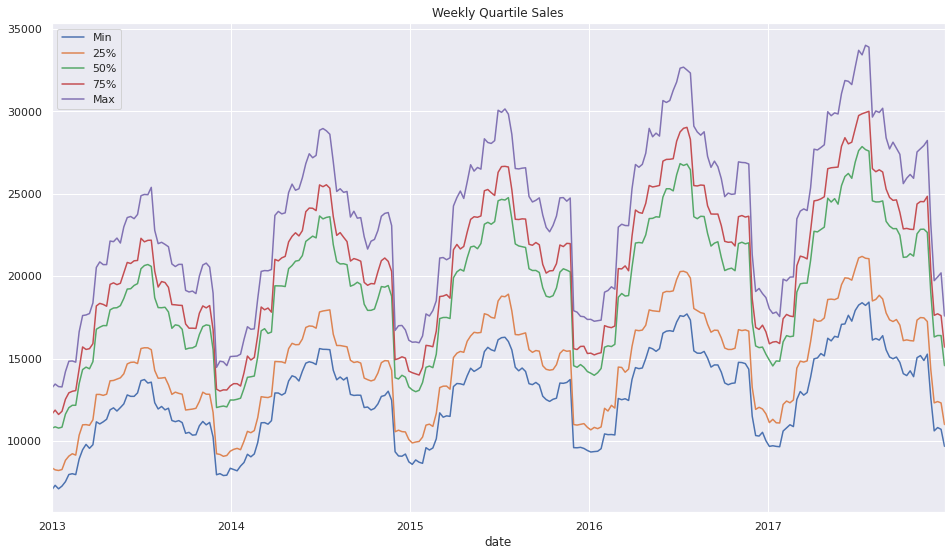

In [ ]:
#Looking at the average trend, percentiles, etc.
eda_df = train.copy()
eda_df = pd.DataFrame(eda_df.groupby(['date','store']).sum()['sales']).unstack()
eda_df = eda_df.resample('7D',label='left').sum()
eda_df.sort_index(inplace = True)

store_qtr = pd.DataFrame(eda_df.quantile([0.0,0.25,0.5,0.75,1.0],axis=1)).transpose()
store_qtr.sort_index(inplace = True)
store_qtr.columns = ['Min','25%','50%','75%','Max']
store_qtr.plot(figsize=(16,9), title='Weekly Quartile Sales')
plt.show()

<Figure size 1152x288 with 0 Axes>

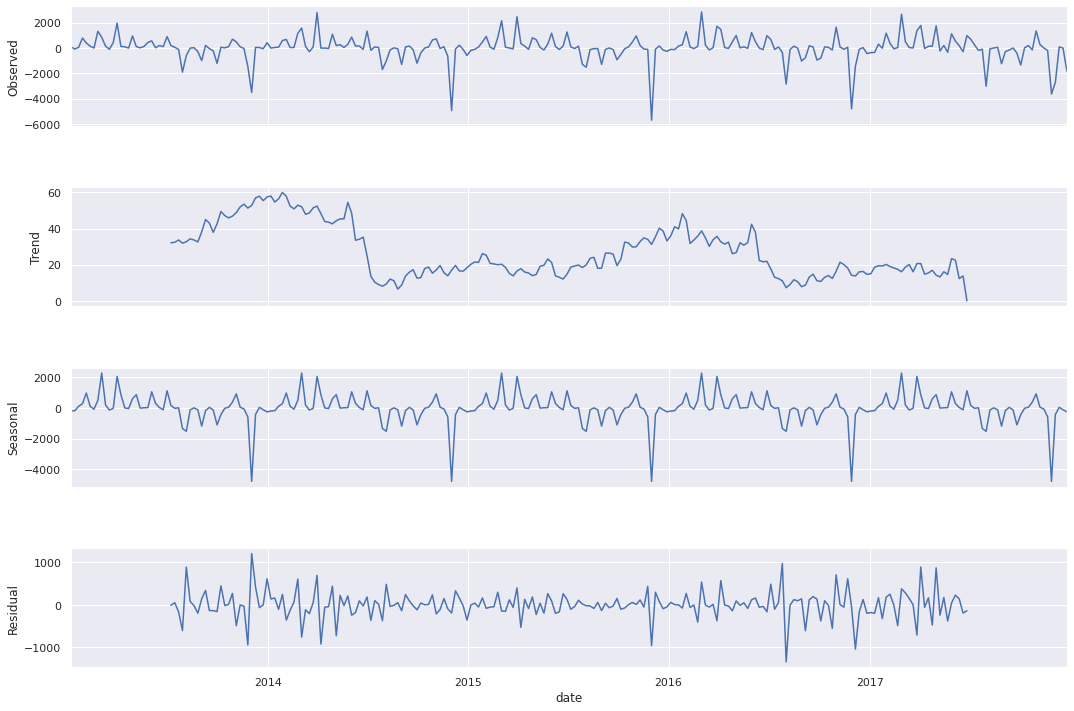

In [ ]:
#Looking for any seasonality trends in the total store sales.
result = seasonal_decompose(pd.DataFrame(store_qtr['50%']).diff(1).iloc[1:,0],model='additive')

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)



Observation: 

TREND: Increasing pattern observed over the period. In this case, the gradual increase underlying trend is observed. (i.e. the total number of sales has increased over a period of time.)

SEASONAILITY: There is a similiar patern that repears after a certain interval of time. There is a certain high and low point that is visible in all intervals.

Next, look into the sales quantity based on day of week and see if some days perform better than other days.

In [ ]:
#Item sales trend
daily_sales_by_item = train.groupby(['item', 'date'], as_index=False)['sales'].sum()
daily_sales_by_item_sc = []
for item in daily_sales_by_item['item'].unique():
    current_item = daily_sales_by_item[(daily_sales_by_item['item'] == item)]
    daily_sales_by_item_sc.append(go.Scatter(x=current_item['date'], y=current_item['sales'], name=('Item %s' % item)))

layout = go.Layout(title='Item daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=daily_sales_by_item_sc, layout=layout)
iplot(fig)


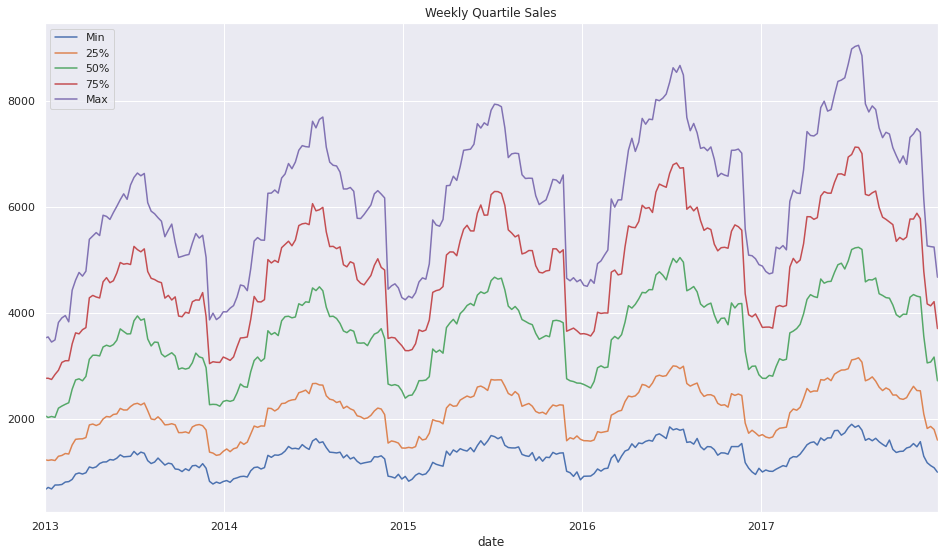

In [ ]:
#Looking at the average trend in quarter percentiles
eda_df = train.copy()
eda_df = pd.DataFrame(eda_df.groupby(['date','item']).sum()['sales']).unstack()
eda_df = eda_df.resample('7D',label='left').sum()
eda_df.sort_index(inplace = True)

item_qtr = pd.DataFrame(eda_df.quantile([0.0,0.25,0.5,0.75,1.0],axis=1)).transpose()
item_qtr.sort_index(inplace = True)
item_qtr.columns = ['Min','25%','50%','75%','Max']
item_qtr.plot(figsize=(16,9), title='Weekly Quartile Sales')
plt.show()

<Figure size 1152x288 with 0 Axes>

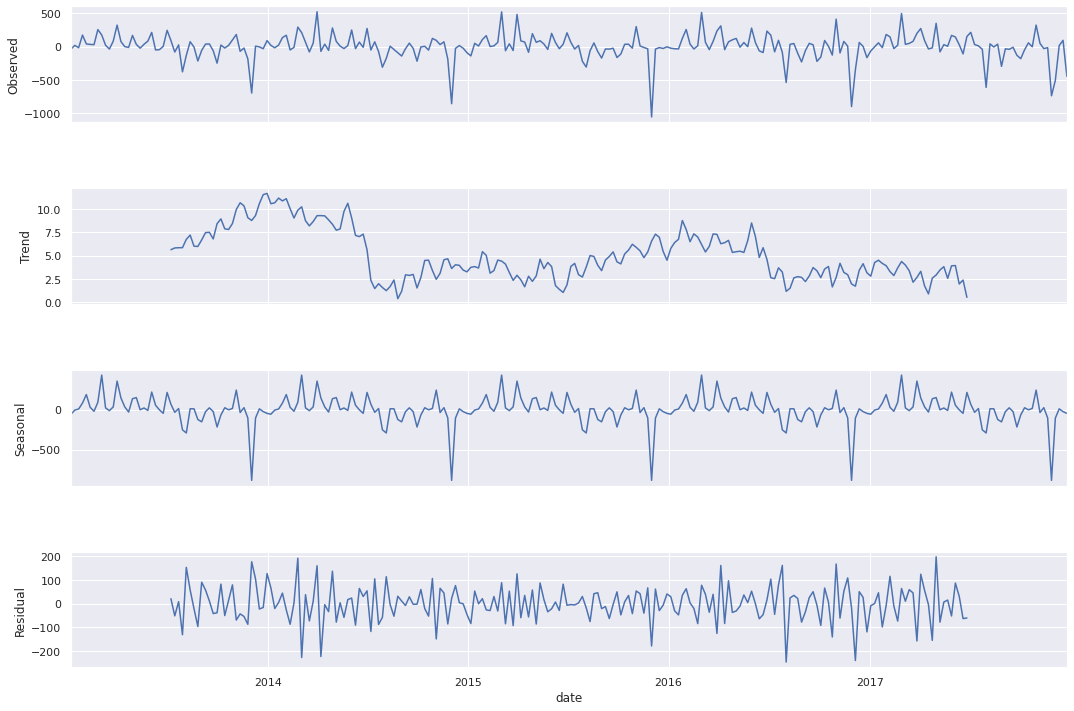

In [ ]:
#Looking for any seasonality trends in the total store sales.
result = seasonal_decompose(pd.DataFrame(item_qtr['50%']).diff(1).iloc[1:,0],model='additive')

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

Observation:

TREND: Increasing pattern observed over the period. In this case, the gradual increase underlying trend is observed. (i.e. the total number of sales has increased over a period of time.)

SEASONAILITY: There is a similiar patern that repears after a certain interval of time. There is a certain high and low point that is visible in all intervals.

## 3. Feature engineering


*   Date related features
*   Lag features
*   Rolling window features



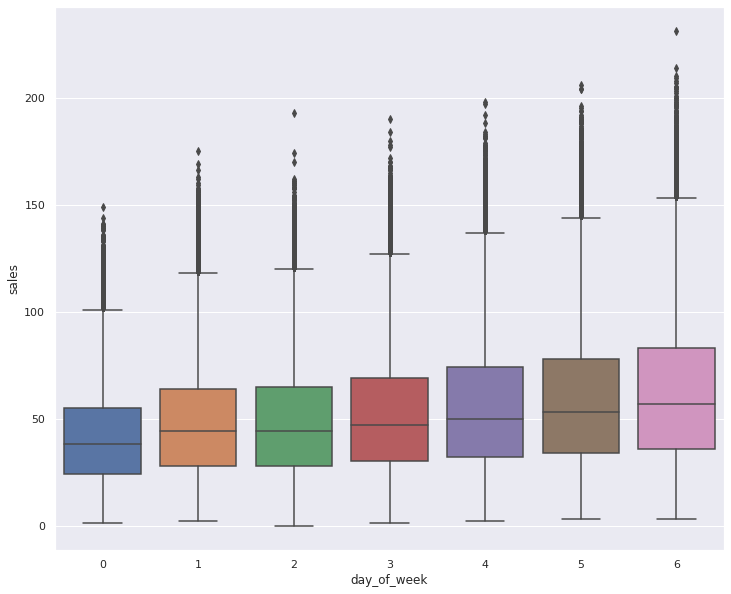

In [ ]:
#Look into the sales quantity based on day of week and see if some days perform better than other days.
features = pd.read_csv(train_path, parse_dates = ['date'], index_col = ['date'])
features['day_of_week'] = features.index.dayofweek
fig, ax = plt.subplots(figsize=(12,10))  
plot = sns.boxplot(x="day_of_week", y="sales", data=features, ax = ax)

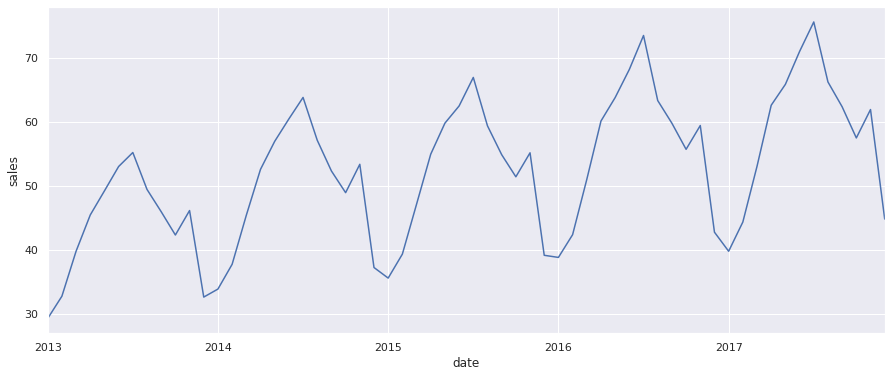

In [ ]:
# Sales pattern throughout 5 years
fdf = pd.read_csv(train_path, parse_dates=['date'], index_col=['date'])
fdf.drop(['item', 'store'], axis = 1, inplace=True)
fdf = fdf['sales'].resample('MS').mean()
fdf = fdf.fillna(fdf.bfill())
fdf.plot(figsize=(15, 6), ylabel = "sales")
plt.show()

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
#Date related features
features = pd.read_csv(train_path, parse_dates = ['date'], index_col = ['date']) # load dataset
features['day'] = features.index.day
features['month'] = features.index.month
features['day_of_week'] = features.index.dayofweek
features['quarter'] = features.index.quarter
features['is_weekend'] = features.apply(lambda features : 1 if ((features['day_of_week'] == 4)|(features['day_of_week'] == 5)|(features['day_of_week'] == 6)) else 0, axis=1)


In [ ]:
holidays = pd.read_csv("data/USHolidayDates.csv")
#holidays = cal.holidays(start=features.index.min(), end=features.index.max())
features['is_holiday'] = features.index.isin(holidays['Date'])
features['is_holiday'] = features.apply(lambda features : 1 if (features['is_holiday']) else 0, axis=1)

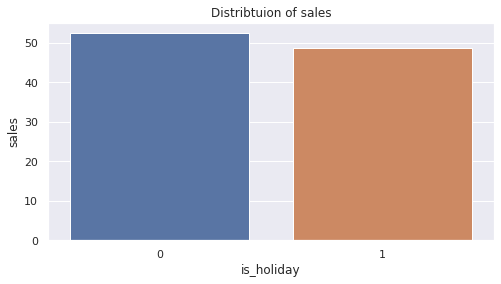

In [ ]:
#Look into the sales for holidays
test = features.copy()
test = test.groupby(['is_holiday'], as_index = False)['sales'].mean()
sns.set(rc={"figure.figsize":(8, 4)})
ax = sns.barplot(data = test, x=test["is_holiday"], y = test["sales"]) .set_title('Distribtuion of sales')

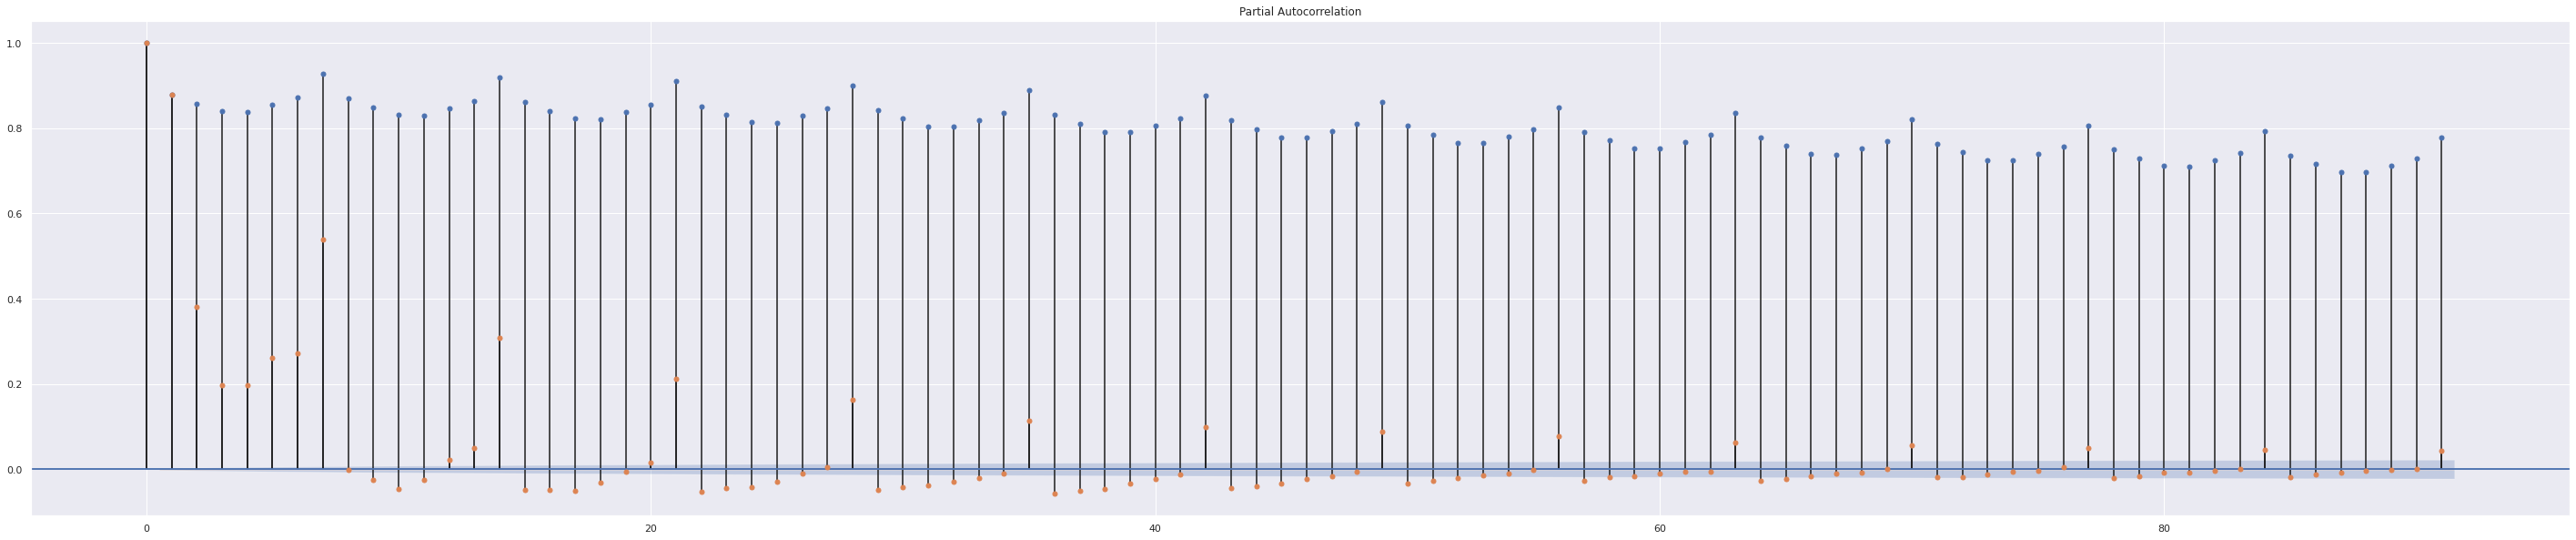

In [ ]:
#Plotting ACF and PACF graphs for lag values 91 and 364
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(50,10))  
fig = plot_acf(features['sales'], lags=91, ax = ax)
fig = plot_pacf(features['sales'], lags=91, ax = ax)
plt.show()

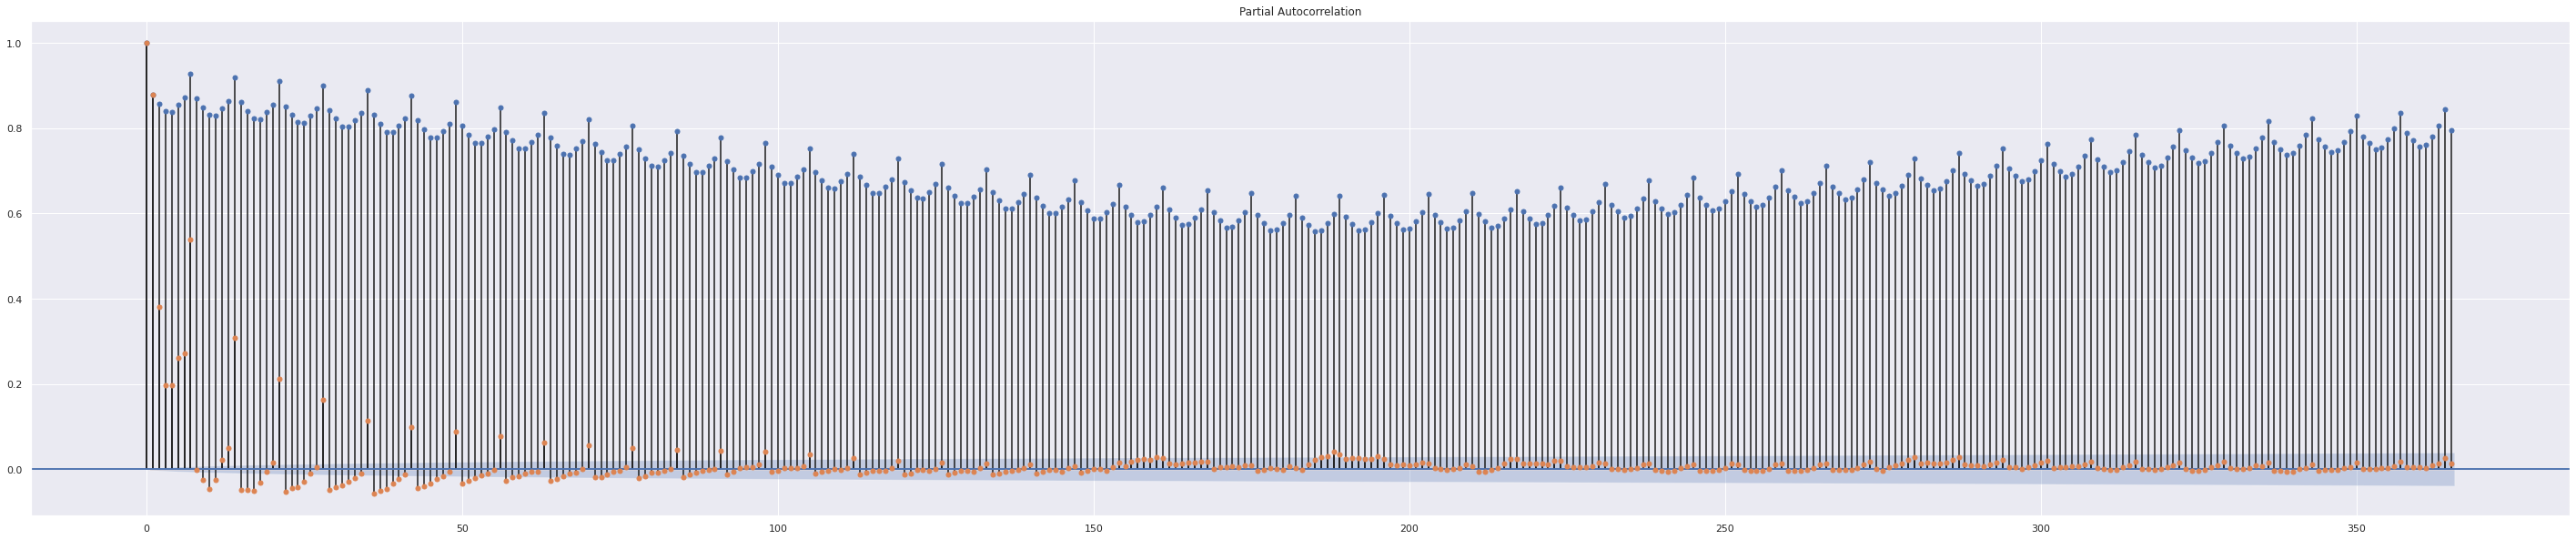

In [ ]:
fig, ax = plt.subplots(figsize=(50,10))  
fig = plot_acf(features['sales'], lags=365, ax = ax)
fig = plot_pacf(features['sales'], lags=365, ax = ax)
plt.show()

Observation: The partial autocorrelation function shows a high correlation with the first lag and lesser correlation with the second and third lag. The autocorrelation function shows a slow decay, which means that the future values have a very high correlation with its past values.

In [ ]:
#Lag features
#lag_features = lag_features[(lag_features["store"] == 1) & (lag_features["item"]==1)]
features['prev_quarter'] = features['sales'].shift(91)
features['prev_year'] = features['sales'].shift(364)
features.dropna(inplace = True)


In [ ]:
#Rolling mean features
features['rolling_mean'] = features['sales'].rolling(window=7).mean()
features.dropna(inplace = True)

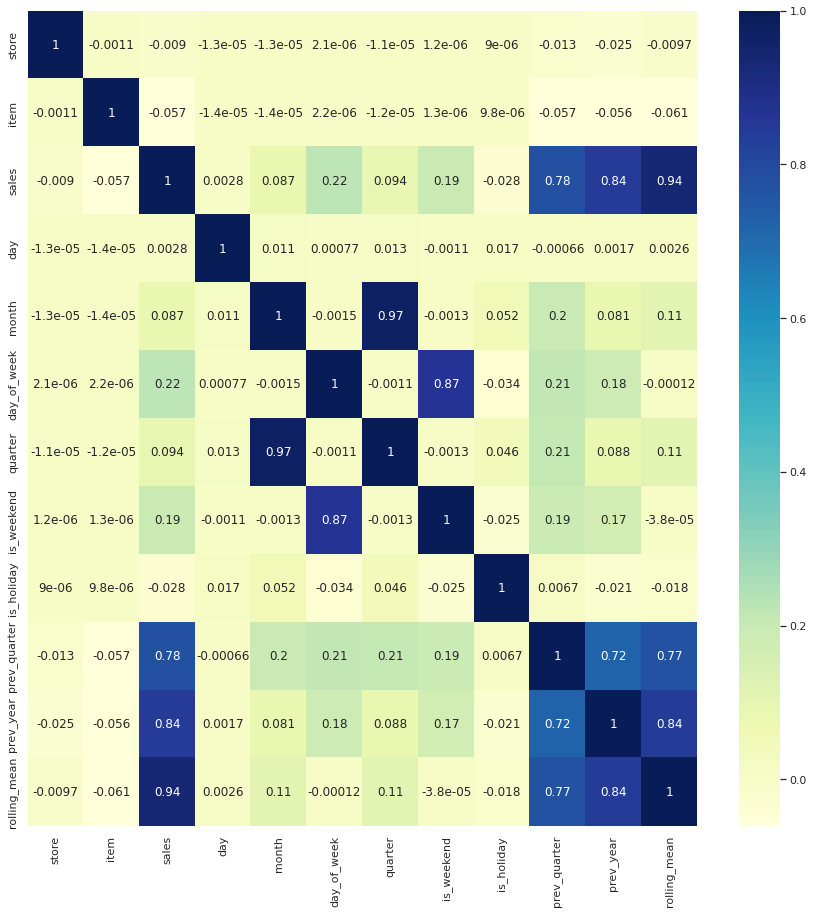

In [ ]:
corr_matrix = features.corr()
fig, ax = plt.subplots(figsize=(15,15))  

sns.heatmap(data = corr_matrix, 
                 cmap="YlGnBu",
                 annot = True)
plt.show()

# SARIMAX





*   Select model
*   Evaluation
*   Prediction




## Select model

In [ ]:
#Load data
df_train = pd.read_csv(train_path, parse_dates=['date'], index_col=['date'])
df_test = pd.read_csv(test_path, parse_dates=['date'], index_col=['date'])

In [ ]:
def set_train_feature():
  train_feature = df_train.copy()
  months = train_feature.index.month
  #Apply one-hot encoding to month feaure
  dummy_months = pd.get_dummies(months)
  dummy_months.columns = ['month-%s' % m for m in dummy_months.columns]
  dummy_months.index = train_feature.index
  
  train_feature['prev_quarter'] = train_feature['sales'].shift(91)
  train_feature['prev_year'] = train_feature['sales'].shift(364)
  train_feature = pd.concat([train_feature, dummy_months], axis=1)
  train_feature.dropna(inplace=True)
  return train_feature

def set_test_feature():
  df_test_ex = df_test.copy()
  months = df_test_ex.index.month
  #Apply one-hot encoding to month feaure
  dummy_months = pd.get_dummies(months)
  dummy_months.columns = ['month-%s' % m for m in dummy_months.columns]
  dummy_months.index = df_test_ex.index
  prev_quarter_dates = df_test_ex.index - datetime.timedelta(days=91)
  prev_year_dates = df_test_ex.index - datetime.timedelta(days=364)

  df_test_ex['prev_quarter'] = df_train.loc[train_feature.index.isin(prev_quarter_dates), 'sales'].values
  df_test_ex['prev_year'] = df_train.loc[train_feature.index.isin(prev_year_dates), 'sales'].values
  df_test_ex = pd.concat([df_test_ex, dummy_months], axis=1)
  for m in range(4, 13):
      df_test_ex['month-%s' % m] = 0
  return df_test_ex

In [ ]:
# Prepare (p,d,q) combinations for grid search
p = 7
d = q = range(0, 3)
# Generate all different combinations of d and q 
pdq = list(itertools.product(d, q))

In [ ]:
def sarimax_grid_search(data, exog):
    ans = []
    for comb in pdq:
        order = (7,) + comb
        try:
            arimax = sm.tsa.statespace.SARIMAX(data.loc['2013-12-31':], exog=exog,
                                           enforce_invertibility=False, enforce_stationarity=False, freq='D',
                                           order=order)
            output = arimax.fit(maxiter=50)
            ans.append([order, output.bic])
            print('SARIMAX {} x BIC Calculated ={}'.format(order, output.bic))
        except:
            continue
    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'bic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
    
    return ans_df

In [ ]:
warnings.filterwarnings("ignore")
# Subsample to shorten process time
s1i1_train = set_train_feature()
s1i1 = s1i1_train.loc[(s1i1_train['store'] == 1) & (s1i1_train['item'] == 1), 'sales']
exog_s1i1 = s1i1_train.loc[(s1i1_train['store'] == 1) & (s1i1_train['item'] == 1)].drop(['store', 'item', 'sales'], axis=1)
best_order = sarimax_grid_search(s1i1, exog_s1i1)
best_order.head()

## Evaluation

In [ ]:
s1i1_train = set_train_feature()
s1i1 = s1i1_train.loc[(s1i1_train['store'] == 1) & (s1i1_train['item'] == 1), 'sales']
exog_s1i1 = s1i1_train.loc[(s1i1_train['store'] == 1) & (s1i1_train['item'] == 1)].drop(['store', 'item', 'sales'], axis=1)

train_data = s1i1.loc['2015-01-01':'2017-10-01'].dropna()
train_exog = exog_s1i1.loc['2015-01-01':'2017-10-01'].dropna()

test_data = s1i1.loc['2017-10-01':'2017-12-31'].dropna()
test_exog = exog_s1i1.loc['2017-10-01':'2017-12-31'].dropna()

In [ ]:
arimax = sm.tsa.statespace.SARIMAX(s1i1.loc['2015-01-01':'2017-10-01'], exog=train_exog,
                                   enforce_invertibility=False, enforce_stationarity=False, freq='D',
                                   order=(7,0,3)).fit()

In [ ]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

prediction = arimax.predict('2017-10-01', '2018-01-01',exog=test_exog)[1:]
print('SARIMAX model MSE: {}'.format(mean_squared_error(prediction, test_data)))
print('SARIMAX model SMAPE: {}'.format(smape(test_data, prediction)))

In [ ]:
pd.DataFrame({'test':test_data,'pred':prediction}).plot();plt.show()

## Prediction


In [ ]:
df_test = set_test_feature()
df_train = set_train_feature()
submission = df_test.reset_index()
submission['sales'] = 0
tic = time.time()

for s in submission['store'].unique():
    for i in submission['item'].unique():
        endog = df_train.loc[(df_train['store'] == s) & (df_train['item'] == i), 'sales']
        exog = df_train.loc[(df_train['store'] == s) & (df_train['item'] == i)].drop(['store', 'item', 'sales'], axis=1)
        arimax = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog,
                                           enforce_invertibility=False, enforce_stationarity=False, freq='D',
                                           order=(7,0,0)).fit()
        exog_test = df_test_ex.loc[(df_test_ex['store'] == s) & (df_test_ex['item'] == i)].drop(['id', 'store', 'item'], axis=1)
        fcst = arimax.predict(start='2017-12-31', end='2018-03-31', dynamic=True, exog=exog_test)
        submission.loc[(submission['store'] == s) & (submission['item'] == i), 'sales'] = fcst.values[1:]
        
        toc = time.time()
        if i % 10 == 0:
            print("Completed store {} item {}. Cumulative time: {:.1f}m".format(s, i, (toc-tic)/60))

In [ ]:
submission.drop(['date', 'store', 'item'], axis=1, inplace=True)
submission.to_csv('/content/SARIMAX.csv', index=False)

# Random Forest

## Import data


In [ ]:
df_train=pd.read_csv(train_path)
df_test= pd.read_csv(test_path, index_col='id')

## Data Handling

In [ ]:
# change date to DateTime for train set
df_train['date'] = pd.to_datetime(df_train['date'])
df_train.dtypes

# change date to DateTime for test set
df_test['date'] = pd.to_datetime(df_test['date'])
df_test.dtypes

In [ ]:
# Feature Engineering for train set

us_holidays = holidays.UnitedStates()

print(type(us_holidays))

print(us_holidays)

#features of type int
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['week'] = df_train['date'].dt.week
df_train['weekofyear'] = df_train['date'].dt.weekofyear
df_train['dayofweek'] = df_train['date'].dt.dayofweek
df_train['weekday'] = df_train['date'].dt.weekday
df_train['dayofyear'] = df_train['date'].dt.dayofyear
df_train['quarter'] = df_train['date'].dt.quarter
df_train['holiday'] =  df_train['date'].map(lambda x: int(x in us_holidays))

#features of type bool
df_train['is_month_start'] = df_train['date'].dt.is_month_start
df_train['is_month_end'] =df_train['date'].dt.is_month_end
df_train['is_quarter_start'] = df_train['date'].dt.is_quarter_start
df_train['is_quarter_end'] = df_train['date'].dt.is_quarter_end
df_train['is_year_start'] = df_train['date'].dt.is_year_start
df_train['is_year_end'] = df_train['date'].dt.is_year_end

In [ ]:
# Feature Engineering for test set
us_holidays = holidays.UnitedStates()

#int
df_test['year'] = df_test['date'].dt.year
df_test['month'] = df_test['date'].dt.month
df_test['day'] = df_test['date'].dt.day
df_test['week'] = df_test['date'].dt.week
df_test['weekofyear'] = df_test['date'].dt.weekofyear
df_test['dayofweek'] = df_test['date'].dt.dayofweek
df_test['weekday'] = df_test['date'].dt.weekday
df_test['dayofyear'] = df_test['date'].dt.dayofyear
df_test['quarter'] = df_test['date'].dt.quarter
df_test['holiday'] =  df_test['date'].map(lambda x: int(x in us_holidays))

#bool
df_test['is_month_start'] = df_test['date'].dt.is_month_start
df_test['is_month_end']= df_test['date'].dt.is_month_end
df_test['is_quarter_start'] = df_test['date'].dt.is_quarter_start
df_test['is_quarter_end'] = df_test['date'].dt.is_quarter_end
df_test['is_year_start'] = df_test['date'].dt.is_year_start
df_test['is_year_end'] = df_test['date'].dt.is_year_end

In [ ]:
# removal of date columns no longer neccessary from train and test set
del df_train['date']
del df_test['date']

## Modeling

In [ ]:
y = df_train['sales']
x = df_train.drop('sales', axis=1) # sales column removed for model training

In [ ]:
## scaling done to perform standardization and bring all features to a common scale
ss = StandardScaler()
xtrain_scaled = ss.fit_transform(x) ## use fit_transform() on training data
xtest_scaled = ss.transform(df_test) ## use transform() on test data

### Build RandomForest Model

In [ ]:
# create a Random Forest regressor object from Random Forest Regressor class
model = RandomForestRegressor(n_estimators=100, min_samples_leaf = 7, random_state=123, bootstrap = True)

# fit the random forest regressor with the training data input xtrain_scaled and output y
# supervised learning : fit random forest regressor with training data
model.fit(xtrain_scaled, y)

In [ ]:
# predict sales with trained model using test data
pred_sales = model.predict(xtest_scaled)

## Evaluation

In [ ]:
#Calculate SMAPE Score
def smape(A, F):
    tmp = 2 * np.abs(F - A) / (np.abs(A) + np.abs(F))
    len_ = np.count_nonzero(~np.isnan(tmp))
    if len_ == 0 and np.nansum(tmp) == 0: # Deals with a special case
        return 100
    return 100 / len_ * np.nansum(tmp)

smape_err = smape(df_train['sales'].to_numpy(), model.predict(xtrain_scaled))
print("SMAPE Score: ", smape_err)

#Calculate R-squared Score
print('Score :',model.score(xtrain_scaled, y))

In [ ]:
# plot actual training dataset output against model output 
pd.DataFrame({'test':df_train['sales'].to_numpy(),'pred':model.predict(xtrain_scaled)}).plot();plt.show()

## Submission

In [ ]:
df_test_submission = pd.read_csv(test_path, index_col='id')
df_test_submission['sales'] = pred_sales
df_test_submission.drop(['date', 'store', 'item'], axis=1, inplace=True)

In [ ]:
df_test_submission.to_csv('/content/RandomForest.csv')

# Prophet

In [ ]:
def smape(A, F):
    tmp = 2 * np.abs(F - A) / (np.abs(A) + np.abs(F))
    len_ = np.count_nonzero(~np.isnan(tmp))
    if len_ == 0 and np.nansum(tmp) == 0: # Deals with a special case
        return 100
    return 100 / len_ * np.nansum(tmp)

In [ ]:
train = pd.read_csv(train_path, parse_dates=['date']) # initiate a new df to avoid any changes that may be made above to the dataset
test = pd.read_csv(test_path, parse_dates=['date'])

train

## Parameters in Prophet:


## Analysing Dataset to find Seasonality & Holiday Parameters

From the EDA, there is seasonality as well as weekend effects on the dataset. The assumption of holiday being a positive correlation wasn't as clear. A test will be carried out to test the effect when holiday is not applied and applied. 


### Deeper Analysis on the dataset seasonality and trends
The EDA looked into yearly seasons and trends.  This portion will look into weekly, monthly and yearly seasonality.


In [ ]:
# storing the dataset data to plot graphs
stores = train['store'].unique()
items = train['item'].unique()

Sales_series = []
IndexSale_series = []
Dates = []

count = 0
for store in stores:
    for item in items:
        sales = train[(train.store==store) & (train.item==item)]['sales'].to_list() # get all the sales of (store, item) pair
        dates = train[(train.store==store) & (train.item==item)]['date'].to_list() # get all the respective dates
        index = [count, item, store]

        Dates.append(dates)
        Sales_series.append(sales)
        IndexSale_series.append(index)
        
        count +=1

#### Weekly Seasonality

In [ ]:
# Check for weekly seasonality using ACF
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = plot_acf(Sales_series[0],lags=70,ax=ax)

Sales_series[0] = store 1, item 1 pair. 1 "stick" refers to 1 date. From the graph, it can be seen that there is a pattern of weekly seasonality. The 1st, 2nd and 7th lag are of much higher correlation which supports EDA's discover of weekend being correlated with sales 

#### Monthly Seasonality

In [ ]:
# Check for monthly seasonality using ACF
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = plot_acf(Sales_series[0],lags=365,ax=ax)

Sales_series[0] = store 1, item 1 pair. 1 "stick" refers to 1 date. In the graph, there is 1 year worth of consecutive dates. It can be seen that there is a dip in sales in the middle of the year, followed by a rebound during end of the year.  

#### Yearly Seasonality

In [ ]:
# Check for yearly seasonality using ACF
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = plot_acf(Sales_series[0],lags=1825,ax=ax)

Sales_series[0] = store 1, item 1 pair. 1 "stick" refers to 1 date. In the graph, there is 5 years worth of consecutive dates. There is a decreasing trend of yearly seasonality. 

## Model

**Note**: Testing model parameters using 1 store item pair to reduce run time

#### Default model with no parameters (SAMPE:  23.27)

In [ ]:
train = pd.read_csv(train_path, parse_dates=['date']) # initiate a new df to avoid any changes that may be made above to the dataset
test = pd.read_csv(test_path, parse_dates=['date'])

df = train[train['store'] == 1][train['item'] == 3]
df = df[["date", "sales"]]
df = df.rename(columns = {"date":"ds","sales":"y"})
df.ds = pd.to_datetime(df.ds, format='%Y-%m')

model = Prophet(daily_seasonality=False,
  weekly_seasonality=False,
  yearly_seasonality=False,
  seasonality_mode='additive',)
model.fit(df)
future = model.make_future_dataframe(periods = 90)

forecast = model.predict(future)
forecast['yhat'] =  np.round(forecast['yhat']).astype(int)
preds = forecast['yhat'][:-90] # get predicted sales from all dates other than the predicted 90 days

sampe_err = smape(df['y'].to_numpy(), preds.to_numpy())
print("SAMPE is: ", sampe_err)

plt.figure(figsize=(15,6))
plt.plot(df.ds, preds, color='red', label =' Predictions')
plt.plot(df.ds, df.y, color='blue', label ='Actual')
plt.legend()
plt.show()

### Model with seasonality (SAMPE:  14.55)

In [ ]:
train = pd.read_csv(train_path, parse_dates=['date']) # initiate a new df to avoid any changes that may be made above to the dataset
test = pd.read_csv(test_path, parse_dates=['date'])

df = train[train['store'] == 1][train['item'] == 3]
df = df[["date", "sales"]]
df = df.rename(columns = {"date":"ds","sales":"y"})
df.ds=pd.to_datetime(df.ds,format='%Y-%m')

model = Prophet(daily_seasonality=False,
  weekly_seasonality=True,
  yearly_seasonality=True,
  seasonality_mode='additive',)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(df)
future = model.make_future_dataframe(periods = 90)

forecast = model.predict(future)
forecast['yhat'] =  np.round(forecast['yhat']).astype(int)
preds = forecast['yhat'][:-90] # get predicted sales from all dates other than the predicted 90 days

sampe_err = smape(df['y'].to_numpy(), preds.to_numpy())
print("SAMPE is: ", sampe_err)

plt.figure(figsize=(15,6))
plt.plot(df.ds, preds, color='red', label =' Predictions')
plt.plot(df.ds, df.y, color='blue', label ='Actual')
plt.legend()
plt.show()

### Default model with season + holiday (SAMPE:  14.46)

In [ ]:
train = pd.read_csv(train_path, parse_dates=['date']) # initiate a new df to avoid any changes that may be made above to the dataset
test = pd.read_csv(test_path, parse_dates=['date'])
holidays = pd.read_csv(holidays_path)

# getting holiday
train['date'] = pd.to_datetime(train['date']) 

holidays.rename(columns={"Date": "ds", "Holiday": "holiday"},inplace=True) # restruct holidays to match model requirement, to be used later in model
holidays['ds'] = pd.to_datetime(holidays['ds']) 

holidays = holidays[(holidays['ds']>train.iloc[0]['date'])&(holidays['ds']<train.iloc[-1]['date'])] # get all relevant holidays to training dataset

holidays["holiday"].unique() # list of holidays to be fed into the model 

df = train[train['store'] == 1][train['item'] == 3]
df = df[["date", "sales"]]
df = df.rename(columns = {"date":"ds","sales":"y"})
df.ds=pd.to_datetime(df.ds,format='%Y-%m')

model = Prophet(daily_seasonality=False,
  weekly_seasonality=True,
  yearly_seasonality=True,
  holidays = holidays, seasonality_mode='additive',)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(df)
future = model.make_future_dataframe(periods = 90)

forecast = model.predict(future)
forecast['yhat'] =  np.round(forecast['yhat']).astype(int)
preds = forecast['yhat'][:-90] # get predicted sales from all dates other than the predicted 90 days

sampe_err = smape(df['y'].to_numpy(), preds.to_numpy())
print("SAMPE is: ", sampe_err)

plt.figure(figsize=(15,6))
plt.plot(df.ds, preds, color='red', label =' Predictions')
plt.plot(df.ds, df.y, color='blue', label ='Actual')
plt.legend()
plt.show()

### Model with season + holiday + Holidays Effect Scale (SMAPE: 14.47 )

In [ ]:
train = pd.read_csv(train_path, parse_dates=['date']) # initiate a new df to avoid any changes that may be made above to the dataset
test = pd.read_csv(test_path, parse_dates=['date'])
holidays = pd.read_csv(holidays_path)

# getting holiday
train['date'] = pd.to_datetime(train['date']) 

holidays.rename(columns={"Date": "ds", "Holiday": "holiday"},inplace=True) # restruct holidays to match model requirement, to be used later in model
holidays['ds'] = pd.to_datetime(holidays['ds']) 

holidays = holidays[(holidays['ds']>train.iloc[0]['date'])&(holidays['ds']<train.iloc[-1]['date'])] # get all relevant holidays to training dataset

holidays["holiday"].unique() # list of holidays to be fed into the model 

df = train[train['store'] == 1][train['item'] == 3]
df = df[["date", "sales"]]
df = df.rename(columns = {"date":"ds","sales":"y"})
df.ds=pd.to_datetime(df.ds,format='%Y-%m')

model = Prophet(daily_seasonality=False,
  weekly_seasonality=True,
  yearly_seasonality=True,
  holidays = holidays, seasonality_mode='additive',holidays_prior_scale=0.7,)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(df)
future = model.make_future_dataframe(periods = 90)

forecast = model.predict(future)
forecast['yhat'] =  np.round(forecast['yhat']).astype(int)
preds = forecast['yhat'][:-90] # get predicted sales from all dates other than the predicted 90 days

sampe_err = smape(df['y'].to_numpy(), preds.to_numpy())
print("SAMPE is: ", sampe_err)

plt.figure(figsize=(15,6))
plt.plot(df.ds, preds, color='red', label =' Predictions')
plt.plot(df.ds, df.y, color='blue', label ='Actual')
plt.legend()
plt.show()

### Model with season + holiday + Log Transform


In [ ]:
train = pd.read_csv(train_path, parse_dates=['date']) # initiate a new df to avoid any changes that may be made above to the dataset
test = pd.read_csv(test_path, parse_dates=['date'])
holidays = pd.read_csv(holidays_path)

# getting holiday
train['date'] = pd.to_datetime(train['date']) 

holidays.rename(columns={"Date": "ds", "Holiday": "holiday"},inplace=True) # restruct holidays to match model requirement, to be used later in model
holidays['ds'] = pd.to_datetime(holidays['ds']) 

holidays = holidays[(holidays['ds']>train.iloc[0]['date'])&(holidays['ds']<train.iloc[-1]['date'])] # get all relevant holidays to training dataset

holidays["holiday"].unique() # list of holidays to be fed into the model 

df = train[train['store'] == 1][train['item'] == 3]
dftemp = train[train['store'] == 1][train['item'] == 3]

df["sales"] = np.log1p(df["sales"])
df = df[["date", "sales"]]
df = df.rename(columns = {"date":"ds","sales":"y"})
df.ds=pd.to_datetime(df.ds,format='%Y-%m')

model = Prophet(daily_seasonality=False,
  weekly_seasonality=True,
  yearly_seasonality=True,
  holidays = holidays, seasonality_mode='additive',)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(df)
future = model.make_future_dataframe(periods = 90)

forecast = model.predict(future)
forecast['yhat'] =  np.expm1(forecast['yhat'])
forecast['yhat'] =  np.round(forecast['yhat']).astype(int)
preds = forecast['yhat'][:-90] # get predicted sales from all dates other than the predicted 90 days

sampe_err = smape(dftemp['sales'].to_numpy(), preds.to_numpy())
print("SAMPE is: ", sampe_err)

plt.figure(figsize=(15,6))
plt.plot(df.ds, preds, color='red', label =' Predictions')
plt.plot(df.ds, dftemp.sales, color='blue', label ='Actual')
plt.legend()
plt.show()

### Final Model

In [ ]:
df = pd.read_csv(train_path)
holidays = pd.read_csv(holidays_path)

# getting holiday
df['date'] = pd.to_datetime(df['date']) 

holidays.rename(columns={"Date": "ds", "Holiday": "holiday"},inplace=True) # restruct holidays to match model requirement, to be used later in model
holidays['ds'] = pd.to_datetime(holidays['ds']) 
holidays = holidays[(holidays['ds']>df.iloc[0]['date'])&(holidays['ds']<df.iloc[-1]['date'])] # get all relevant holidays to training dataset

In [ ]:
train = pd.read_csv(train_path, parse_dates=['date'], index_col=['date'])
test = pd.read_csv(test_path, parse_dates=['date'], index_col=['date']) # initiate a new df to avoid any changes that may be made above to the dataset

results = test.reset_index()
results['sales'] = 0

stores = df['store'].unique()
items = df['item'].unique()

# model can only take in 1 pair of (store and item) each time
# loop through each store and (each item in each store) to fit into the model and make 3 months prediction
for store in stores :
    for item in items:        
        to_train = train.loc[(train['store'] == store) & (train['item'] == item)].reset_index()
        to_train.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True) # rename column to ds and y, as per model requirement
        
        to_train['y'] = np.log1p(to_train['y']) # applying Log Transform to stablise variances 
        
        model = Prophet(
            daily_seasonality=False,
            weekly_seasonality=True,
            yearly_seasonality=True,
            holidays = holidays, seasonality_mode='additive',) # setting model parameters 
        model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        model.fit(to_train[['ds', 'y']]) # fit data into model
        
        future = model.make_future_dataframe(periods=len(test.index.unique()), include_history=False) # Since test dataset is of 3 months, using the length of test dataset ensures all row will be predicted
        forecast = model.predict(future) # make prediction
        
        results.loc[(results['store'] == store) & (results['item'] == item),'sales'] = np.expm1(forecast['yhat']).values # store result and convert log back 

results.drop(['date', 'store', 'item'], axis=1, inplace=True) # drop columns that kaggle don't require
results['sales'] = np.round(results['sales']).astype(int) # round the result to whole number
results.to_csv('/content/Prophet.csv', index=False) # output to csv 

# Combine with Ensemble Learning

## Ensemble learning with thresholding on 3 models

In [ ]:
#import results of diff CSV
rf_df = pd.read_csv('/content/RandomForest.csv')
arima_df = pd.read_csv('/content/SARIMAX.csv') #SARIMAX
pp_df = pd.read_csv('/content/Prophet.csv')

#init
algo_df = [rf_df,arima_df,pp_df]
algo_score_arr = [13.71,16.15,13.28]
algo_weights= []

#gen weights
total = sum(algo_score_arr)
for score in algo_score_arr:
  algo_weights.append(score/total*100)

#lowest SMAPE will be the default df
default = algo_score_arr.index(min(algo_score_arr))

In [ ]:
#convert sales value into array for computation
sales_arr = []
for df in algo_df:
  sales_arr.append(df.sales.to_numpy())

### Finding optimal threshold

In [ ]:
swapNumArr = []
xaxis = []
for threshold in range(1,40):
  xaxis.append(threshold)
  new_results = []
  numberOfSwaps = 0
  for i in range(0,len(sales_arr[0])):
    difference_arr = []
    algoSales_1 = sales_arr[0][i]
    algoSales_2 = sales_arr[1][i]
    algoSales_3 = sales_arr[2][i]

    difference_arr.append(abs(algoSales_1-algoSales_2))
    difference_arr.append(abs(algoSales_1-algoSales_3))
    difference_arr.append(abs(algoSales_2-algoSales_3))

    max_value = max(difference_arr)
    if max_value > threshold:
      numberOfSwaps +=1 #use for analysis

      min_value = min(difference_arr)
      min_index = difference_arr.index(min_value)
      if min_index==0:
        new_results.append((algoSales_1+algoSales_2)/2)
      elif min_index==1:
        new_results.append((algoSales_1+algoSales_3)/2)
      elif min_index==2:
        new_results.append((algoSales_2+algoSales_3)/2)
    else:
      new_results.append(sales_arr[default][i])
  swapNumArr.append(numberOfSwaps)
  print(f"number of swaps:{numberOfSwaps} -- threshold:{threshold}")

In [ ]:
#Displaying the number of difference value between both dataset
diff_arr = []
index_arr = []
for i in range(0,len(sales_arr[0])):
  index_arr.append(i)
  difference_arr = []
  algoSales_1 = sales_arr[0][i]
  algoSales_2 = sales_arr[1][i]
  algoSales_3 = sales_arr[2][i]

  difference_arr.append(abs(algoSales_1-algoSales_2))
  difference_arr.append(abs(algoSales_1-algoSales_3))
  difference_arr.append(abs(algoSales_2-algoSales_3))

  max_value = max(difference_arr) 
  max_index = difference_arr.index(max_value)
  if max_index==0:
    diff_arr.append(round(abs(algoSales_1-algoSales_2)))
  elif max_index==1:
    diff_arr.append(round(abs(algoSales_1-algoSales_3)))
  elif max_index==2:
    diff_arr.append(round(abs(algoSales_2-algoSales_3)))

plt.figure(figsize=( 20,10))
plt.xticks(np.arange(0, 25+1, 1))
n_bins = max(diff_arr)
plt.hist(diff_arr, bins=n_bins)
plt.xlabel('Threshold Value')
plt.ylabel('Affected values')
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(xaxis,swapNumArr)
plt.title('Number of change to final result')
plt.xlabel('Threshold Value')
plt.ylabel('swaps')
plt.show()

### Applying threshold value

In [ ]:
#threshold is use to tell the algo when to use averaging
threshold = 3

In [ ]:
new_results = []
numberOfSwaps = 0
for i in range(0,len(sales_arr[0])):
  difference_arr = []
  algoSales_1 = sales_arr[0][i]
  algoSales_2 = sales_arr[1][i]
  algoSales_3 = sales_arr[2][i]

  difference_arr.append(abs(algoSales_1-algoSales_2))
  difference_arr.append(abs(algoSales_1-algoSales_3))
  difference_arr.append(abs(algoSales_2-algoSales_3))
  max_value = max(difference_arr)
  if max_value > threshold:
    numberOfSwaps +=1 #use for analysis

    min_value = min(difference_arr)
    min_index = difference_arr.index(min_value)
    if min_index==0:
      new_results.append((algoSales_1+algoSales_2)/2)
    elif min_index==1:
      new_results.append((algoSales_1+algoSales_3)/2)
    elif min_index==2:
      new_results.append((algoSales_2+algoSales_3)/2)
  else:
    new_results.append(sales_arr[default][i])
print(f"number of swaps:{numberOfSwaps}")

In [ ]:
print(f"Percentage of data changed:{(numberOfSwaps/len(sales_arr[0]))*100}%")

In [ ]:
plt.figure(figsize=(18, 8))
#show difference in before and after results
viewrow = 100

#Prophet
x1 = df.index
y1 = sales_arr[2]
# plotting the line 2 points 
plt.plot(x1[:viewrow], y1[:viewrow], label = "Prophet")

#Randomforest
x2 = df.index
y2 = sales_arr[0]
# plotting the line 2 points 
plt.plot(x2[:viewrow], y2[:viewrow], label = "RandomForest")

#Arima
x3 = df.index
y3 = sales_arr[1]
# plotting the line 2 points 
plt.plot(x3[:viewrow], y3[:viewrow], label = "SARIMAX")

#predicted
x4 = df.index
y4 = new_results
# plotting the line 1 points 
plt.plot(x4[:viewrow], y4[:viewrow], label = "Modified")

plt.xlabel('x - axis(ID)')
# Set the y axis label of the current axis.
plt.ylabel('y - axis(Sales)')
# Set a title of the current axes.
plt.title(' Prophet vs RandomForest vs SARIMAX vs Modified ')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [ ]:
#gen CSV
data = []
df_combined = pd.DataFrame(data, columns=['id', 'sales'])
df_combined['sales'] = new_results
df_combined['id'] = df.index

In [ ]:
df_combined.to_csv('/content/submission_V1.csv', index=False)

##Ensemble learning with thresholding on 2 models

In [ ]:
#import results of diff CSV
rf_df = pd.read_csv('data/results/RandomForest.csv')
pp_df = pd.read_csv('data/results/Prophet.csv')

#init
algo_df = [rf_df,pp_df]
algo_score_arr = [13.71,13.28]
algo_weights= []

#gen weights
total = sum(algo_score_arr)
for score in algo_score_arr:
  algo_weights.append(score/total*100)

#lowest SMAPE will be the default df
default = algo_score_arr.index(min(algo_score_arr))

#convert sales value into array for computation
sales_arr = []
for df in algo_df:
  sales_arr.append(df.sales.to_numpy())

In [ ]:
#Displaying the number of difference value between both dataset
diff_arr = []
index_arr = []
for index in range(0,len(sales_arr[0])):
  index_arr.append(index)
  algoSales_1 = sales_arr[0][index]
  algoSales_2 = sales_arr[1][index]
  diff_arr.append(round(abs(algoSales_1-algoSales_2)))
#plt.figure(figsize=( 20,10))
#plt.plot(index_arr, diff_arr, '.', color='orange');

plt.figure(figsize=( 20,10))
plt.xticks(np.arange(0, 25+1, 1))
n_bins = max(diff_arr)
plt.hist(diff_arr, bins=n_bins)
plt.xlabel('Threshold Value')
plt.ylabel('Affected values')
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(xaxis,swapNumArr)
plt.title('Number of change to final result')
plt.xlabel('Threshold Value')
plt.ylabel('swaps')
plt.show()

In [ ]:
swapNumArr = []
xaxis = []
for threshold in range(1,40):
  xaxis.append(threshold)
  new_results = []
  numberOfSwaps = 0
  for i in range(0,len(sales_arr[0])):
    difference_arr = []
    algoSales_1 = sales_arr[0][i]
    algoSales_2 = sales_arr[1][i]

    max_value = abs(algoSales_1-algoSales_2)
    if max_value > threshold:
      numberOfSwaps +=1 #use for analysis
      new_results.append(abs((algoSales_1+algoSales_2)/2))
    else:
      new_results.append(sales_arr[default][i])
  swapNumArr.append(numberOfSwaps)
  print(f"number of swaps:{numberOfSwaps} -- threshold:{threshold}")

In [ ]:
threshold = 1

In [ ]:
new_results = []
numberOfSwaps = 0
for i in range(0,len(sales_arr[0])):
  difference_arr = []
  algoSales_1 = sales_arr[0][i]
  algoSales_2 = sales_arr[1][i]

  max_value = abs(algoSales_1-algoSales_2)
  if max_value > threshold:
    numberOfSwaps +=1 #use for analysis
    new_results.append(abs((algoSales_1+algoSales_2)/2))
  else:
    new_results.append(sales_arr[default][i])
print(f"number of swaps:{numberOfSwaps}")

In [ ]:
print(f"Percentage of data changed:{(numberOfSwaps/len(sales_arr[0]))*100}%")

In [ ]:
#gen CSV
data = []
df_combined = pd.DataFrame(data, columns=['id', 'sales'])
df_combined['sales'] = new_results
df_combined['id'] = df.index

In [ ]:
df_combined.to_csv('/content/submission_best.csv', index=False)

In [ ]:
plt.figure(figsize=(18, 8))
#show difference in before and after results
viewrow = 100

#Prophet
x1 = df.index
y1 = sales_arr[1]
# plotting the line 2 points 
plt.plot(x1[:viewrow], y1[:viewrow], label = "Prophet")

#Prophet
x2 = df.index
y2 = sales_arr[0]
# plotting the line 2 points 
plt.plot(x2[:viewrow], y2[:viewrow], label = "RandomForest")

#predicted
x3 = df.index
y3 = new_results
# plotting the line 1 points 
plt.plot(x3[:viewrow], y3[:viewrow], label = "Modified")


plt.xlabel('x - axis(ID)')
# Set the y axis label of the current axis.
plt.ylabel('y - axis(Sales)')
# Set a title of the current axes.
plt.title(' Prophet vs RandomForest vs Modified ')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()